# 함수 및 라이브러리

In [20]:
import sys
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

sys.path.insert(0, r"c:\Users\tjrrj\vscode\doritest")

## 가설 검증

In [21]:
'''
===================================================================
통계 검정 함수 모음 (개인 분석용)
===================================================================

compare_groups(df, y_cont, x_cat, alpha=0.05)
    - Y연속형을 X범주형 그룹별로 비교
    - T-test, ANOVA, Wilcoxon, Kruskal-Wallis
    
test_correlation(df, y_cont, x_cont, alpha=0.05)
    - Y연속형과 X연속형의 상관분석
    - Pearson, Spearman

test_independence(df, y_cat, x_cat, alpha=0.05)
    - Y범주형과 X범주형의 독립성 검정
    - Chi² Test

예시:
    # 체중이 직업/파트별로 다른가?
    res = compare_groups(df, '체중', ['직업', '파트'])
    
    # 체중과 헤모글로빈/ODI의 상관관계는?
    res = test_correlation(df, '체중', ['헤모글로빈', 'ODI'])
    
    # 고혈압여부가 직업/파트와 연관있는가?
    res = test_independence(df, '고혈압여부', ['직업', '파트'])
===================================================================
'''

import numpy as np
import pandas as pd
from scipy import stats


# ===================================================================
# 상수
# ===================================================================
DEFAULT_ALPHA = 0.05
DEFAULT_POWER_THRESHOLD = 0.8
MIN_SAMPLE_SIZE = 3
MIN_GROUP_SAMPLE_SIZE = 2
LOW_EXPECTED_FREQ_THRESHOLD = 5
LOW_EXPECTED_FREQ_RATIO = 0.2
NONPARAMETRIC_EFFICIENCY = 0.95  # 비모수 검정의 상대적 효율성


# ===================================================================
# 검정력 분석 함수
# ===================================================================
def calculate_power_ttest(n1, n2, effect_size, alpha=0.05):
    """
    독립표본 T-test 검정력 계산
    
    Parameters
    ----------
    n1, n2 : int
        각 그룹의 표본 크기
    effect_size : float
        Cohen's d
    alpha : float
        유의수준
    
    Returns
    -------
    float : 검정력 (0~1)
    """
    from scipy.stats import nct
    
    df = n1 + n2 - 2
    pooled_n = (n1 * n2) / (n1 + n2)
    noncentrality = effect_size * np.sqrt(pooled_n)
    critical_t = stats.t.ppf(1 - alpha / 2, df)
    
    power = 1 - nct.cdf(critical_t, df, noncentrality) + nct.cdf(-critical_t, df, noncentrality)
    return power


def calculate_power_anova(group_sizes, effect_size_f, alpha=0.05):
    """
    ANOVA 검정력 계산
    
    Parameters
    ----------
    group_sizes : list
        각 그룹의 표본 크기 리스트
    effect_size_f : float
        Cohen's f
    alpha : float
        유의수준
    
    Returns
    -------
    float : 검정력 (0~1)
    """
    from scipy.stats import ncf
    
    k = len(group_sizes)
    N = sum(group_sizes)
    df1 = k - 1
    df2 = N - k
    
    noncentrality = (effect_size_f ** 2) * N
    critical_f = stats.f.ppf(1 - alpha, df1, df2)
    
    power = 1 - ncf.cdf(critical_f, df1, df2, noncentrality)
    return power


def calculate_power_chi2(n, effect_size_w, df, alpha=0.05):
    """
    카이제곱 검정력 계산
    
    Parameters
    ----------
    n : int
        총 표본 크기
    effect_size_w : float
        Cohen's w (= sqrt(chi2/n))
    df : int
        자유도
    alpha : float
        유의수준
    
    Returns
    -------
    float : 검정력 (0~1)
    """
    from scipy.stats import ncx2
    
    noncentrality = (effect_size_w ** 2) * n
    critical_chi2 = stats.chi2.ppf(1 - alpha, df)
    
    power = 1 - ncx2.cdf(critical_chi2, df, noncentrality)
    return power


def calculate_power_correlation(n, r, alpha=0.05):
    """
    상관계수 검정력 계산 (Fisher's z 변환 기반)
    
    Parameters
    ----------
    n : int
        표본 크기
    r : float
        상관계수
    alpha : float
        유의수준
    
    Returns
    -------
    float : 검정력 (0~1)
    """
    if n < 4 or abs(r) >= 1:
        return np.nan
    
    z_r = np.arctanh(r)  # Fisher's z 변환
    se = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    
    power = 1 - stats.norm.cdf(z_crit - z_r / se) + stats.norm.cdf(-z_crit - z_r / se)
    return min(max(power, 0), 1)


def calculate_cohens_d(group1, group2):
    """Cohen's d 계산 (두 그룹 간 효과 크기)"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    if pooled_std == 0:
        return 0
    
    return (np.mean(group1) - np.mean(group2)) / pooled_std


def calculate_cohens_f(groups):
    """Cohen's f 계산 (ANOVA 효과 크기)"""
    grand_mean = np.mean(np.concatenate(groups))
    group_means = [np.mean(g) for g in groups]
    group_sizes = [len(g) for g in groups]
    N = sum(group_sizes)
    
    between_var = sum(n * (m - grand_mean) ** 2 for n, m in zip(group_sizes, group_means)) / N
    within_var = sum((len(g) - 1) * np.var(g, ddof=1) for g in groups) / (N - len(groups))
    
    if within_var == 0:
        return 0
    
    return np.sqrt(between_var / within_var)


def calculate_cramers_v(chi2, n, min_dim):
    """Cramer's V 계산 (카이제곱 효과 크기)"""
    if n == 0 or min_dim <= 1:
        return 0
    return np.sqrt(chi2 / (n * (min_dim - 1)))


def interpret_effect_size(effect_size, test_type):
    """효과 크기 해석"""
    if pd.isna(effect_size):
        return "-"
    
    thresholds = {
        'd': [(0.2, '작음'), (0.5, '중간'), (0.8, '큼')],
        'f': [(0.1, '작음'), (0.25, '중간'), (0.4, '큼')],
        'w': [(0.1, '작음'), (0.3, '중간'), (0.5, '큼')],
        'r': [(0.1, '작음'), (0.3, '중간'), (0.5, '큼')]
    }
    
    for threshold, label in thresholds.get(test_type, []):
        if abs(effect_size) < threshold:
            return label
    return '큼'


def format_power_result(power, threshold=DEFAULT_POWER_THRESHOLD):
    """검정력 결과 포맷팅"""
    if pd.isna(power):
        return "-"
    
    power_pct = power * 100
    
    if power >= threshold:
        return f"{power_pct:.1f}%"
    else:
        return f"{power_pct:.1f}% (⚠낮음)"


# ===================================================================
# 헬퍼 함수
# ===================================================================
def check_normality(series, alpha):
    """정규성 검정 (normaltest)"""
    try:
        _, p_value = stats.normaltest(series.values)
        is_normal = p_value >= alpha
        label = "정규성o" if is_normal else "정규성x"
        return is_normal, p_value, label
    except Exception:
        return False, np.nan, "검정불가"


def check_equal_variance(groups, alpha):
    """등분산 검정 (Bartlett)"""
    try:
        _, p_value = stats.bartlett(*groups)
        is_equal_variance = p_value >= alpha
        label = "등분산" if is_equal_variance else "이분산"
        return is_equal_variance, p_value, label
    except Exception:
        return None, np.nan, "검정실패"


def create_result_row(y_col, x_col, y_type, x_type,
                      normal_label, variance_label,
                      model, p_value, hypothesis,
                      sample_info, effect_size, effect_label, power):
    """결과 딕셔너리 생성"""
    return {
        'Y변수': y_col,
        'X변수': x_col,
        'Y타입': y_type,
        'X타입': x_type,
        '정규성': normal_label,
        '등분산': variance_label,
        '검정모델': model,
        'p값': p_value,
        '가설': hypothesis,
        '표본수': sample_info,
        '효과크기': effect_size,
        '효과해석': effect_label,
        '검정력': power
    }


# ===================================================================
# 1. Y연속 / X범주: 집단 간 평균 비교
# ===================================================================
def compare_groups(
    df,
    y_cont,
    x_cat,
    alpha=DEFAULT_ALPHA,
    blank_as_nan=False,
    dropna=True
):
    '''
    compare_groups(df, y_cont, x_cat, alpha=0.05)
    
    Y연속형을 X범주형 그룹별로 비교
    
    예시:
        # 체중이 직업별로 다른가?
        compare_groups(df, '체중', '직업')
        
        # 체중이 직업/파트/등급별로 각각 다른가?
        compare_groups(df, '체중', ['직업', '파트', '등급'])
    
    플로우:
        Y 정규성검정
        ├─ 정규 → Bartlett 등분산검정
        │   ├─ 등분산 + 2집단 → T-test(등분산)
        │   ├─ 등분산 + 3집단↑ → ANOVA
        │   ├─ 이분산 + 2집단 → T-test(이분산)
        │   └─ 이분산 + 3집단↑ → Kruskal-Wallis
        └─ 비정규
            ├─ 2집단 → Wilcoxon(ranksums)
            └─ 3집단↑ → Kruskal-Wallis
    '''
    x_list = [x_cat] if isinstance(x_cat, (str, int)) else list(x_cat)
    
    base = df.copy()
    
    results = []
    
    for x_col in x_list:
        work_df = base.copy()
        if blank_as_nan:
            work_df[x_col] = work_df[x_col].replace("", np.nan)
        if dropna:
            work_df = work_df.dropna(subset=[x_col])
        
        y_values = pd.to_numeric(work_df[y_cont], errors="coerce")
        if dropna:
            y_values = y_values.dropna()
        
        # 그룹별 데이터 추출
        groups = []
        group_names = []
        for group_name in work_df[x_col].unique():
            group_values = pd.to_numeric(
                work_df.loc[work_df[x_col] == group_name, y_cont],
                errors="coerce"
            )
            if dropna:
                group_values = group_values.dropna()
            
            has_enough_samples = group_values.size >= MIN_GROUP_SAMPLE_SIZE
            if has_enough_samples:
                groups.append(group_values.values)
                group_names.append(group_name)
        
        group_count = len(groups)
        group_sizes = [len(g) for g in groups]
        total_n = sum(group_sizes)
        sample_info = f"총{total_n} ({'/'.join(map(str, group_sizes))})"
        
        # 검정 불가
        if group_count < 2:
            results.append(create_result_row(
                y_cont, x_col, '연속형', '범주형',
                "-", "-",
                "검정불가(그룹/표본 부족)",
                np.nan, "귀무",
                sample_info, np.nan, "-", "-"
            ))
            continue
        
        # 1) 정규성 검정
        is_normal, _, normal_label = check_normality(y_values, alpha)
        
        # 2) 등분산 검정 (정규일 때만)
        variance_label = "-"
        is_equal_variance = None
        
        if is_normal:
            is_equal_variance, var_p, var_result = check_equal_variance(groups, alpha)
            variance_label = var_result
        
        # 3) 검정 선택 및 검정력 계산
        is_two_groups = group_count == 2
        is_three_or_more = group_count >= 3
        is_nonparametric = False
        
        if is_two_groups:
            effect_d = abs(calculate_cohens_d(groups[0], groups[1]))
            
            if is_normal:
                if is_equal_variance:
                    _, p_value = stats.ttest_ind(groups[0], groups[1], equal_var=True)
                    model = "T-test(등분산)"
                else:
                    _, p_value = stats.ttest_ind(groups[0], groups[1], equal_var=False)
                    model = "T-test(이분산)"
                power = calculate_power_ttest(group_sizes[0], group_sizes[1], effect_d, alpha)
            else:
                _, p_value = stats.ranksums(groups[0], groups[1])
                model = "Wilcoxon(ranksums)"
                is_nonparametric = True
                power = calculate_power_ttest(group_sizes[0], group_sizes[1], effect_d, alpha)
                power = power * NONPARAMETRIC_EFFICIENCY if pd.notna(power) else np.nan
            
            effect_size = effect_d
            effect_label = interpret_effect_size(effect_d, 'd')
        
        elif is_three_or_more:
            effect_f = calculate_cohens_f(groups)
            
            should_use_anova = is_normal and is_equal_variance
            if should_use_anova:
                _, p_value = stats.f_oneway(*groups)
                model = "ANOVA"
                power = calculate_power_anova(group_sizes, effect_f, alpha)
            else:
                _, p_value = stats.kruskal(*groups)
                model = "Kruskal-Wallis"
                is_nonparametric = True
                power = calculate_power_anova(group_sizes, effect_f, alpha)
                power = power * NONPARAMETRIC_EFFICIENCY if pd.notna(power) else np.nan
            
            effect_size = effect_f
            effect_label = interpret_effect_size(effect_f, 'f')
        
        hypothesis = "대립" if p_value < alpha else "귀무"
        power_str = format_power_result(power)
        
        results.append(create_result_row(
            y_cont, x_col, '연속형', '범주형',
            normal_label, variance_label,
            model, round(p_value, 4), hypothesis,
            sample_info, round(effect_size, 3), effect_label, power_str
        ))
    
    return pd.DataFrame(results)


# ===================================================================
# 2. Y연속 / X연속: 상관분석
# ===================================================================
def test_correlation(
    df,
    y_cont,
    x_cont,
    alpha=DEFAULT_ALPHA,
    dropna=True
):
    '''
    test_correlation(df, y_cont, x_cont, alpha=0.05)
    
    Y연속형과 X연속형의 상관분석
    
    예시:
        # 체중과 헤모글로빈의 상관관계는?
        test_correlation(df, '체중', '헤모글로빈')
        
        # 체중과 여러 변수들의 상관관계는?
        test_correlation(df, '체중', ['헤모글로빈', 'ODI', '나이'])
    
    플로우:
        X,Y 정규성검정
        ├─ 둘 다 정규 → Pearson
        └─ 하나라도 비정규 → Spearman
    '''
    x_list = [x_cont] if isinstance(x_cont, (str, int)) else list(x_cont)
    
    results = []
    
    for x_col in x_list:
        y_values = pd.to_numeric(df[y_cont], errors="coerce")
        x_values = pd.to_numeric(df[x_col], errors="coerce")
        
        if dropna:
            valid_mask = y_values.notna() & x_values.notna()
            y_values = y_values[valid_mask]
            x_values = x_values[valid_mask]
        
        sample_size = len(y_values)
        sample_info = f"n={sample_size}"
        
        # 검정 불가
        has_insufficient_samples = sample_size < MIN_SAMPLE_SIZE
        is_y_constant = y_values.nunique(dropna=True) < 2
        is_x_constant = x_values.nunique(dropna=True) < 2
        
        if has_insufficient_samples or is_y_constant or is_x_constant:
            results.append(create_result_row(
                y_cont, x_col, '연속형', '연속형',
                "검정불가", "-",
                "검정불가(상수/표본부족)",
                np.nan, "귀무",
                sample_info, np.nan, "-", "-"
            ))
            continue
        
        # 정규성 검정
        is_y_normal, _, _ = check_normality(y_values, alpha)
        is_x_normal, _, _ = check_normality(x_values, alpha)
        
        y_label = "o" if is_y_normal else "x"
        x_label = "o" if is_x_normal else "x"
        normal_label = f"Y:{y_label}/X:{x_label}"
        
        # 상관분석
        both_normal = is_y_normal and is_x_normal
        
        try:
            if both_normal:
                r, p_value = stats.pearsonr(y_values.values, x_values.values)
                model = "Pearson"
            else:
                r, p_value = stats.spearmanr(y_values.values, x_values.values)
                model = "Spearman"
            
            power = calculate_power_correlation(sample_size, r, alpha)
            if not both_normal and pd.notna(power):
                power = power * NONPARAMETRIC_EFFICIENCY
                
        except Exception:
            r, p_value = np.nan, np.nan
            model = "검정불가(수치오류)"
            power = np.nan
        
        hypothesis = "대립" if (pd.notna(p_value) and p_value < alpha) else "귀무"
        effect_label = interpret_effect_size(r, 'r')
        power_str = format_power_result(power)
        
        results.append(create_result_row(
            y_cont, x_col, '연속형', '연속형',
            normal_label, "-",
            model,
            round(p_value, 4) if pd.notna(p_value) else np.nan,
            hypothesis,
            sample_info,
            round(r, 3) if pd.notna(r) else np.nan,
            effect_label,
            power_str
        ))
    
    return pd.DataFrame(results)


# ===================================================================
# 3. Y범주 / X범주: 독립성 검정
# ===================================================================
def test_independence(
    df,
    y_cat,
    x_cat,
    alpha=DEFAULT_ALPHA,
    dropna=True,
    yates=True
):
    '''
    test_independence(df, y_cat, x_cat, alpha=0.05)
    
    Y범주형과 X범주형의 독립성 검정 (Chi² Test)
    
    예시:
        # 고혈압여부가 직업과 연관있는가?
        test_independence(df, '고혈압여부', '직업')
        
        # 고혈압여부가 직업/파트/등급과 각각 연관있는가?
        test_independence(df, '고혈압여부', ['직업', '파트', '등급'])
    '''
    x_list = [x_cat] if isinstance(x_cat, (str, int)) else list(x_cat)
    
    results = []
    
    for x_col in x_list:
        y_values = df[y_cat]
        x_values = df[x_col]
        
        if dropna:
            valid_mask = y_values.notna() & x_values.notna()
            y_values = y_values[valid_mask]
            x_values = x_values[valid_mask]
        
        table = pd.crosstab(y_values, x_values)
        total_n = table.values.sum()
        sample_info = f"n={total_n} ({table.shape[0]}x{table.shape[1]})"
        
        # 검정 불가
        has_insufficient_categories = (
            table.shape[0] < 2 or
            table.shape[1] < 2 or
            total_n == 0
        )
        
        if has_insufficient_categories:
            results.append(create_result_row(
                y_cat, x_col, '범주형', '범주형',
                "-", "-",
                "검정불가(범주<2)",
                np.nan, "귀무",
                sample_info, np.nan, "-", "-"
            ))
            continue
        
        # 카이제곱
        is_2x2 = table.shape == (2, 2)
        use_yates = yates and is_2x2
        
        chi2, p_value, dof, expected = stats.chi2_contingency(table, correction=use_yates)
        
        model = "Chi²(Yates)" if use_yates else "Chi²"
        
        # 기대도수 경고
        expected_flat = expected.ravel()
        has_very_low = (expected_flat < 1).any()
        has_many_low = (expected_flat < LOW_EXPECTED_FREQ_THRESHOLD).sum() / expected_flat.size > LOW_EXPECTED_FREQ_RATIO
        
        if has_very_low or has_many_low:
            model += "(⚠기대도수↓)"
        
        # 효과 크기 및 검정력
        min_dim = min(table.shape)
        effect_w = calculate_cramers_v(chi2, total_n, min_dim)
        effect_label = interpret_effect_size(effect_w, 'w')
        power = calculate_power_chi2(total_n, effect_w, dof, alpha)
        power_str = format_power_result(power)
        
        hypothesis = "대립" if p_value < alpha else "귀무"
        
        results.append(create_result_row(
            y_cat, x_col, '범주형', '범주형',
            "-", "-",
            model, round(p_value, 4), hypothesis,
            sample_info, round(effect_w, 3), effect_label, power_str
        ))
    
    return pd.DataFrame(results)



## 다변량

In [22]:
'''
===================================================================
다중회귀 분석 함수 (주피터 노트북용)
===================================================================

run_regression(df, y_cont, x_cols, alpha=0.05)

예시:
    result = run_regression(df, '체중', ['ODI', '파트', '고혈압여부', '등급'])
    
    result['baseline']    # 범주형 기준값 정보
    result['model']       # 모델 통계 + 해석
    result['summary']     # 변수별 상세 결과
    result['significant'] # 유의한 변수만
===================================================================
'''

import numpy as np
import pandas as pd


# ===================================================================
# 상수
# ===================================================================
DEFAULT_ALPHA = 0.05
VIF_THRESHOLD = 10
MIN_UNIQUE_FOR_CONTINUOUS = 10


# ===================================================================
# 다중회귀 분석
# ===================================================================
def run_regression(
    df,
    y_cont,
    x_cols,
    alpha=DEFAULT_ALPHA,
    vif_threshold=VIF_THRESHOLD
):
    '''
    run_regression(df, y_cont, x_cols, alpha=0.05)
    
    다중회귀 분석 (Y연속형 ~ X변수들)
    
    Returns
    -------
    dict of DataFrames:
        'baseline': 범주형 기준값 정보 (n, %, 적정여부)
        'model': 모델 통계 + 해석
        'summary': 변수별 계수, p값, VIF 등
        'significant': 유의한 변수만 필터링
        'statsmodel': statsmodels 모델 객체
    '''
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    x_list = [x_cols] if isinstance(x_cols, str) else list(x_cols)
    
    work_df = df[[y_cont] + x_list].dropna().copy()
    total_n = len(work_df)
    
    Y = work_df[y_cont].astype(float)
    
    # X 전처리
    X_parts = []
    baseline_data = []
    
    for col in x_list:
        series = work_df[col]
        
        is_categorical = (
            series.dtype == 'object' or
            series.dtype.name == 'category' or
            series.nunique() < MIN_UNIQUE_FOR_CONTINUOUS
        )
        
        if is_categorical:
            value_counts = series.value_counts()
            most_frequent = value_counts.index[0]
            most_frequent_n = value_counts.iloc[0]
            most_frequent_pct = most_frequent_n / total_n * 100
            
            # 적정 여부 판단 (10% 이상이면 OK)
            is_adequate = most_frequent_pct >= 10
            status = "✓적정" if is_adequate else "⚠소수"
            
            baseline_data.append({
                '변수': col,
                '기준값(Baseline)': most_frequent,
                'n': most_frequent_n,
                '비율': f"{most_frequent_pct:.1f}%",
                '상태': status
            })
            
            dummies = pd.get_dummies(series, prefix=col, drop_first=False, dtype=float)
            baseline_col = f"{col}_{most_frequent}"
            
            if baseline_col in dummies.columns:
                dummies = dummies.drop(columns=[baseline_col])
            
            X_parts.append(dummies)
        else:
            X_parts.append(series.astype(float).to_frame())
    
    X = pd.concat(X_parts, axis=1)
    X_const = sm.add_constant(X)
    
    # 회귀 적합
    model = sm.OLS(Y, X_const).fit()
    
    # Baseline DataFrame
    baseline_df = pd.DataFrame(baseline_data) if baseline_data else pd.DataFrame()
    
    # 모델 통계 + 해석
    r2 = model.rsquared
    adj_r2 = model.rsquared_adj
    f_stat = model.fvalue
    f_pval = model.f_pvalue
    
    # R² 해석
    if r2 >= 0.7:
        r2_interp = "강한 설명력"
    elif r2 >= 0.4:
        r2_interp = "중간 설명력"
    elif r2 >= 0.2:
        r2_interp = "약한 설명력"
    else:
        r2_interp = "매우 약한 설명력"
    
    # F검정 해석
    f_interp = "모델 유의" if f_pval < alpha else "모델 비유의"
    
    model_data = [
        {'항목': 'R²', '값': f"{r2:.4f}", '해석': f"{r2_interp} (변수들이 Y 분산의 {r2*100:.1f}% 설명)"},
        {'항목': 'Adj R²', '값': f"{adj_r2:.4f}", '해석': "변수 수 보정된 설명력"},
        {'항목': 'F통계량', '값': f"{f_stat:.4f}", '해석': f_interp},
        {'항목': 'F p값', '값': f"{f_pval:.4f}" if f_pval > 1e-10 else "<0.0001", '해석': f"{'p<' + str(alpha) + ' → 최소 하나의 변수가 유의' if f_pval < alpha else 'p≥' + str(alpha) + ' → 모델 전체적으로 비유의'}"},
        {'항목': '표본수', '값': f"{int(model.nobs)}", '해석': ""},
        {'항목': '독립변수', '값': f"{len(x_list)}개", '해석': ""},
    ]
    model_df = pd.DataFrame(model_data)
    
    # 변수별 결과
    summary_data = []
    
    # 각 범주의 비율 계산용
    category_ratios = {}
    for col in x_list:
        series = work_df[col]
        is_categorical = (
            series.dtype == 'object' or
            series.dtype.name == 'category' or
            series.nunique() < MIN_UNIQUE_FOR_CONTINUOUS
        )
        if is_categorical:
            value_counts = series.value_counts()
            for val, cnt in value_counts.items():
                key = f"{col}_{val}"
                category_ratios[key] = f"{cnt}({cnt/total_n*100:.1f}%)"
    
    # 표준화 계수 계산을 위한 표준편차
    y_std = Y.std()
    x_stds = {}
    for col in X_const.columns:
        if col != 'const':
            x_stds[col] = X_const[col].std()
    
    for var_name in model.params.index:
        coef = model.params[var_name]
        p_val = model.pvalues[var_name]
        std_err = model.bse[var_name]
        conf_low, conf_high = model.conf_int().loc[var_name]
        
        if var_name == 'const':
            vif = np.nan
            vif_str = "-"
            ratio_str = "-"
            beta = np.nan
        else:
            try:
                col_idx = list(X_const.columns).index(var_name)
                vif = variance_inflation_factor(X_const.values, col_idx)
                vif_str = f"{vif:.2f}"
            except:
                vif = np.nan
                vif_str = "-"
            
            # 비율 찾기
            ratio_str = category_ratios.get(var_name, "-")
            
            # 표준화 계수 (Beta)
            x_std = x_stds.get(var_name, 1)
            beta = coef * (x_std / y_std) if y_std != 0 else 0
        
        is_significant = p_val < alpha
        sig_label = "⭐유의" if is_significant else "-"
        
        # VIF 경고
        vif_warning = ""
        if pd.notna(vif) and vif > vif_threshold:
            vif_warning = "⚠공선성"
        
        # 방향
        if var_name == 'const':
            direction = ""
        else:
            direction = "↑양(+)" if coef > 0 else "↓음(-)"
        
        summary_data.append({
            '변수': var_name,
            'n(비율)': ratio_str,
            '계수': round(coef, 4),
            'Beta': round(beta, 4) if pd.notna(beta) else np.nan,
            '방향': direction,
            '표준오차': round(std_err, 4),
            'p값': round(p_val, 4),
            '유의': sig_label,
            '95%CI': f"[{conf_low:.3f}, {conf_high:.3f}]",
            'VIF': vif_str,
            '비고': vif_warning
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # 영향도 계산 - const 제외, 유의한 변수 기준
    sig_mask = (summary_df['유의'] == '⭐유의') & (summary_df['변수'] != 'const')
    sig_df = summary_df[sig_mask].copy()
    
    if len(sig_df) > 0:
        # Beta 절대값 기준 영향도 계산
        sig_df['|Beta|'] = sig_df['Beta'].abs()
        total_abs_beta = sig_df['|Beta|'].sum()
        
        if total_abs_beta > 0:
            sig_df['영향도'] = (sig_df['|Beta|'] / total_abs_beta * 100).round(1)
            sig_df['영향도_str'] = sig_df['영향도'].apply(lambda x: f"{x}%")
        else:
            sig_df['영향도'] = 0
            sig_df['영향도_str'] = "-"
        
        # 영향도 순으로 정렬
        sig_df = sig_df.sort_values('|Beta|', ascending=False)
        
        # 누적 영향도 추가
        if total_abs_beta > 0:
            sig_df['누적영향도'] = (sig_df['|Beta|'].cumsum() / total_abs_beta * 100).round(1)
            sig_df['누적영향도_str'] = sig_df['누적영향도'].apply(lambda x: f"{x}%")
        else:
            sig_df['누적영향도'] = 0
            sig_df['누적영향도_str'] = "-"
        
        # 컬럼 정리
        sig_df['영향도'] = sig_df['영향도_str']
        sig_df['누적영향도'] = sig_df['누적영향도_str']
        sig_df = sig_df.drop(columns=['|Beta|', '영향도_str', '누적영향도_str'])
        sig_df = sig_df.reset_index(drop=True)
        
        # 컬럼 순서 재배치
        col_order = ['변수', 'n(비율)', '계수', 'Beta', '방향', '영향도', '누적영향도', 'p값', '유의', '95%CI', 'VIF', '비고']
        sig_df = sig_df[[c for c in col_order if c in sig_df.columns]]
    else:
        sig_df = pd.DataFrame()
    
    return {
        'baseline': baseline_df,
        'model': model_df,
        'summary': summary_df,
        'significant': sig_df,
        'statsmodel': model
    }


# ===================================================================
# 교호작용 검정
# ===================================================================
def test_interaction(
    df,
    y_cont,
    x_cols,
    interaction_pairs,
    alpha=DEFAULT_ALPHA
):
    '''
    test_interaction(df, y_cont, x_cols, interaction_pairs)
    
    교호작용(Interaction) 효과 검정
    
    예시:
        # 파트와 등급의 교호작용 검정
        test_interaction(
            df, '체중', 
            ['ODI', '파트', '등급'],
            interaction_pairs=[('파트', '등급')]
        )
        
        # 여러 교호작용 동시 검정
        test_interaction(
            df, '체중',
            ['파트', '등급', '고혈압여부'],
            interaction_pairs=[('파트', '등급'), ('파트', '고혈압여부')]
        )
    
    Returns
    -------
    dict:
        'comparison': 주효과 vs 교호작용 모델 비교
        'interactions': 교호작용 항 결과
        'summary': 전체 모델 결과
    '''
    import statsmodels.api as sm
    from scipy import stats
    
    x_list = [x_cols] if isinstance(x_cols, str) else list(x_cols)
    
    work_df = df[[y_cont] + x_list].dropna().copy()
    total_n = len(work_df)
    
    Y = work_df[y_cont].astype(float)
    
    # 1) 주효과 모델 (baseline)
    X_main_parts = []
    baseline_info = {}
    
    for col in x_list:
        series = work_df[col]
        is_categorical = (
            series.dtype == 'object' or
            series.dtype.name == 'category' or
            series.nunique() < MIN_UNIQUE_FOR_CONTINUOUS
        )
        
        if is_categorical:
            most_frequent = series.value_counts().index[0]
            baseline_info[col] = most_frequent
            dummies = pd.get_dummies(series, prefix=col, drop_first=False, dtype=float)
            baseline_col = f"{col}_{most_frequent}"
            if baseline_col in dummies.columns:
                dummies = dummies.drop(columns=[baseline_col])
            X_main_parts.append(dummies)
        else:
            X_main_parts.append(series.astype(float).to_frame())
    
    X_main = pd.concat(X_main_parts, axis=1)
    X_main_const = sm.add_constant(X_main)
    model_main = sm.OLS(Y, X_main_const).fit()
    
    # 2) 교호작용 항 생성
    interaction_terms = []
    interaction_names = []
    
    for var1, var2 in interaction_pairs:
        series1 = work_df[var1]
        series2 = work_df[var2]
        
        is_cat1 = series1.dtype == 'object' or series1.nunique() < MIN_UNIQUE_FOR_CONTINUOUS
        is_cat2 = series2.dtype == 'object' or series2.nunique() < MIN_UNIQUE_FOR_CONTINUOUS
        
        if is_cat1 and is_cat2:
            # 범주 × 범주
            for val1 in series1.unique():
                if val1 == baseline_info.get(var1):
                    continue
                for val2 in series2.unique():
                    if val2 == baseline_info.get(var2):
                        continue
                    term_name = f"{var1}_{val1}:{var2}_{val2}"
                    term = ((series1 == val1) & (series2 == val2)).astype(float)
                    interaction_terms.append(term)
                    interaction_names.append(term_name)
        
        elif is_cat1 and not is_cat2:
            # 범주 × 연속
            for val1 in series1.unique():
                if val1 == baseline_info.get(var1):
                    continue
                term_name = f"{var1}_{val1}:{var2}"
                term = (series1 == val1).astype(float) * series2.astype(float)
                interaction_terms.append(term)
                interaction_names.append(term_name)
        
        elif not is_cat1 and is_cat2:
            # 연속 × 범주
            for val2 in series2.unique():
                if val2 == baseline_info.get(var2):
                    continue
                term_name = f"{var1}:{var2}_{val2}"
                term = series1.astype(float) * (series2 == val2).astype(float)
                interaction_terms.append(term)
                interaction_names.append(term_name)
        
        else:
            # 연속 × 연속
            term_name = f"{var1}:{var2}"
            term = series1.astype(float) * series2.astype(float)
            interaction_terms.append(term)
            interaction_names.append(term_name)
    
    # 3) 교호작용 포함 모델
    if interaction_terms:
        X_inter = pd.concat([
            X_main,
            pd.DataFrame(dict(zip(interaction_names, interaction_terms)))
        ], axis=1)
    else:
        X_inter = X_main.copy()
    
    X_inter_const = sm.add_constant(X_inter)
    model_inter = sm.OLS(Y, X_inter_const).fit()
    
    # 4) 모델 비교 (F-test)
    ssr_main = model_main.ssr  # 잔차제곱합
    ssr_inter = model_inter.ssr
    df_main = model_main.df_resid
    df_inter = model_inter.df_resid
    
    # F = ((SSR_main - SSR_inter) / (df_main - df_inter)) / (SSR_inter / df_inter)
    if df_main > df_inter:
        f_stat = ((ssr_main - ssr_inter) / (df_main - df_inter)) / (ssr_inter / df_inter)
        f_pval = 1 - stats.f.cdf(f_stat, df_main - df_inter, df_inter)
    else:
        f_stat = np.nan
        f_pval = np.nan
    
    # 비교 결과
    comparison_data = [
        {
            '모델': '주효과만',
            'R²': round(model_main.rsquared, 4),
            'Adj_R²': round(model_main.rsquared_adj, 4),
            'AIC': round(model_main.aic, 1),
            '잔차': round(ssr_main, 2)
        },
        {
            '모델': '교호작용 포함',
            'R²': round(model_inter.rsquared, 4),
            'Adj_R²': round(model_inter.rsquared_adj, 4),
            'AIC': round(model_inter.aic, 1),
            '잔차': round(ssr_inter, 2)
        }
    ]
    comparison_df = pd.DataFrame(comparison_data)
    
    # 교호작용 유의성 판단
    r2_improve = model_inter.rsquared - model_main.rsquared
    is_interaction_sig = f_pval < alpha if pd.notna(f_pval) else False
    
    if is_interaction_sig:
        verdict = f"⭐교호작용 유의 (F={f_stat:.2f}, p={f_pval:.4f}, R²↑{r2_improve*100:.1f}%p)"
    else:
        verdict = f"교호작용 비유의 (p={f_pval:.4f}) → 주효과 모델 사용 권장"
    
    # 교호작용 항 상세
    interaction_data = []
    for term_name in interaction_names:
        if term_name in model_inter.params.index:
            coef = model_inter.params[term_name]
            p_val = model_inter.pvalues[term_name]
            sig = "⭐유의" if p_val < alpha else "-"
            direction = "↑양(+)" if coef > 0 else "↓음(-)"
            
            interaction_data.append({
                '교호작용항': term_name,
                '계수': round(coef, 4),
                '방향': direction,
                'p값': round(p_val, 4),
                '유의': sig
            })
    
    interaction_df = pd.DataFrame(interaction_data) if interaction_data else pd.DataFrame()
    
    # 전체 모델 summary
    summary_data = []
    for var_name in model_inter.params.index:
        coef = model_inter.params[var_name]
        p_val = model_inter.pvalues[var_name]
        sig = "⭐유의" if p_val < alpha else "-"
        direction = "" if var_name == 'const' else ("↑양(+)" if coef > 0 else "↓음(-)")
        
        summary_data.append({
            '변수': var_name,
            '계수': round(coef, 4),
            '방향': direction,
            'p값': round(p_val, 4),
            '유의': sig
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    return {
        'comparison': comparison_df,
        'verdict': verdict,
        'interactions': interaction_df,
        'summary': summary_df,
        'model_main': model_main,
        'model_inter': model_inter
    }



- 표준화 계수 = 계수 × (X의 표준편차 / Y의 표준편차)
- 영향도(%) = |Beta_i| / Σ|Beta| × 100

# 데이터 조회

## 데이터 저장소 체크

In [23]:
# ===================================================================
# 테스트
# ===================================================================
if __name__ == "__main__":
    np.random.seed(42)
    
    # 큰 효과 크기를 위한 데이터
    test_df = pd.DataFrame({
        '직업': np.random.choice(['개발자', '디자이너', '기획자'], 100),
        '파트': ['A팀'] * 50 + ['B팀'] * 50,
        '등급': np.random.choice([1, 2, 3, 4, 5], 100),
        '체중': np.concatenate([
            np.random.normal(65, 8, 50),  # A팀
            np.random.normal(75, 8, 50)   # B팀 (차이 있음)
        ]),
        'ODI': np.random.normal(50, 15, 100),
        '헤모글로빈': np.random.normal(14, 2, 100) + np.arange(100) * 0.05,  # 상관관계
        '고혈압여부': np.random.choice(['있음', '없음'], 100),
        '합격여부': np.random.choice(['합격', '불합격'], 100),
        '비정규값': np.random.exponential(scale=10, size=100)
    })
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)
    
df1 = test_df

## 이상치 설정(선택)

In [ ]:
LIMIT_WEIGHT = 90
LIMIT_SCORE = '합격'

cond1 = df1['체중'] > LIMIT_WEIGHT
cond2 = (df1['합격여부'] > LIMIT_SCORE)
 
df1['is_outlier'] = np.where(( cond1 | cond2 ), True, False)

          체중  is_outlier
0  76.468124       False
1  73.526350       False
2  45.009927       False
3  76.842628       False
4  82.269828       False


# 통계 분석

## 기술적 데이터 분석(DDA)

### 데이터 구조와 타입

In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   직업      100 non-null    object 
 1   파트      100 non-null    object 
 2   등급      100 non-null    int64  
 3   체중      100 non-null    float64
 4   ODI     100 non-null    float64
 5   헤모글로빈   100 non-null    float64
 6   고혈압여부   100 non-null    object 
 7   합격여부    100 non-null    object 
 8   비정규값    100 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 7.2+ KB


In [26]:
df1.head()

,직업,파트,등급,체중,ODI,헤모글로빈,고혈압여부,합격여부,비정규값
0,기획자,A팀,4,76.468124,22.971680,12.820694,있음,불합격,13.371431
1,개발자,A팀,3,73.526350,57.015756,13.453398,없음,합격,2.012400
2,기획자,A팀,3,45.009927,26.728491,13.277419,있음,합격,8.300330
3,기획자,A팀,1,76.842628,42.342602,16.118047,있음,불합격,18.370288
4,개발자,A팀,3,82.269828,39.005733,14.407136,있음,불합격,0.934367


In [27]:
df1.tail()

,직업,파트,등급,체중,ODI,헤모글로빈,고혈압여부,합격여부,비정규값
95,개발자,B팀,2,66.783506,61.858910,20.365111,있음,합격,23.845127
96,개발자,B팀,2,82.062701,59.492787,20.648305,있음,합격,3.800848
97,기획자,B팀,4,71.405565,16.187620,20.475713,있음,합격,8.874766
98,개발자,B팀,5,78.349116,13.151103,16.198556,있음,불합격,11.487969
99,개발자,B팀,1,69.174566,48.852019,17.675529,있음,합격,6.013862


In [28]:
df1.describe()

,등급,체중,ODI,헤모글로빈,비정규값
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.870000,70.214922,49.889619,16.299588,10.617297
std,1.425985,9.102326,16.857509,2.580561,10.070073
min,1.000000,45.009927,13.151103,7.621809,0.027146
25%,1.000000,64.264531,38.883640,14.764044,3.849767
50%,3.000000,70.224604,50.418065,16.141623,8.059887
75%,4.000000,76.248879,61.565108,17.825865,14.062450
max,5.000000,93.186761,97.805500,21.877720,58.981690


### 결측치

In [29]:
df1.describe(exclude='number')

,직업,파트,고혈압여부,합격여부
count,100,100,100,100
unique,3,2,2,2
top,디자이너,A팀,있음,합격
freq,36,50,50,51


In [30]:
df1.isnull().sum()

직업       0
파트       0
등급       0
체중       0
ODI      0
헤모글로빈    0
고혈압여부    0
합격여부     0
비정규값     0
dtype: int64

<Axes: >

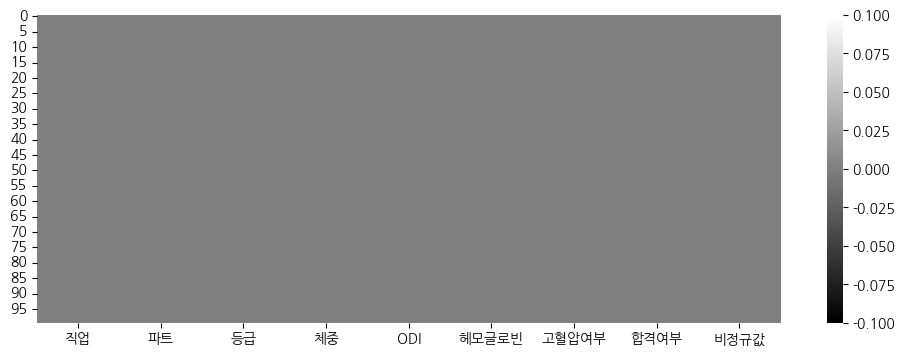

In [31]:
plt.figure(figsize=(12, 4))
sns.heatmap(df1.isnull(), cmap='grey')

### 시각화

In [32]:
# 아래 hist랑 같이보기
df1.describe()

,등급,체중,ODI,헤모글로빈,비정규값
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.870000,70.214922,49.889619,16.299588,10.617297
std,1.425985,9.102326,16.857509,2.580561,10.070073
min,1.000000,45.009927,13.151103,7.621809,0.027146
25%,1.000000,64.264531,38.883640,14.764044,3.849767
50%,3.000000,70.224604,50.418065,16.141623,8.059887
75%,4.000000,76.248879,61.565108,17.825865,14.062450
max,5.000000,93.186761,97.805500,21.877720,58.981690


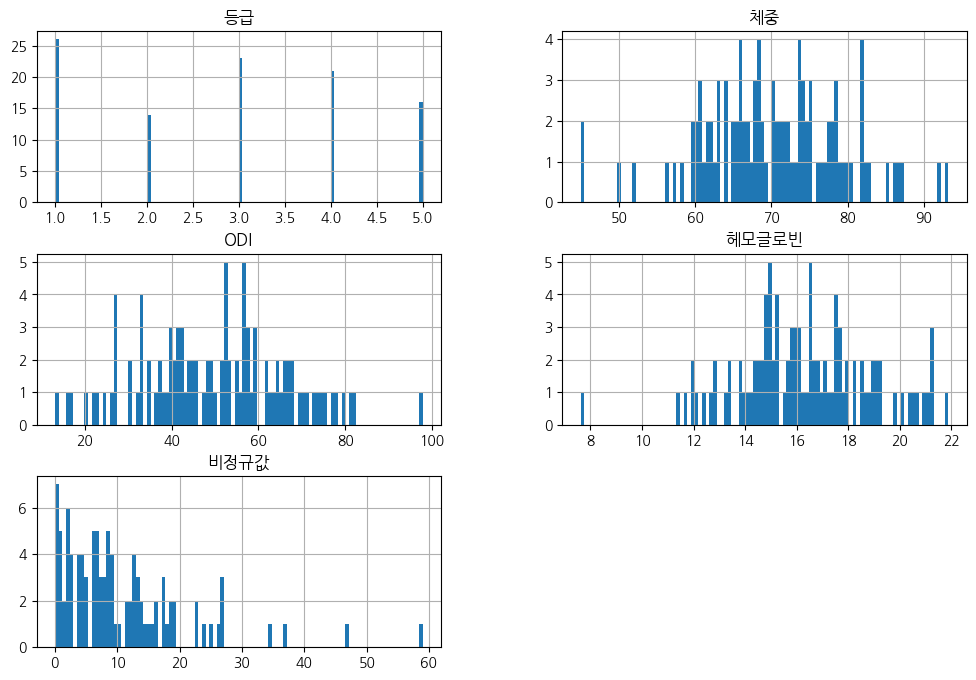

In [33]:
df1.hist(figsize=(12, 8), bins=100);

C:\Users\tjrrj\AppData\Local\Temp\ipykernel_11888\2458911391.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].text(j, counts[j]/2, f'{val:.1f}%', ha='center', fontweight='bold')
C:\Users\tjrrj\AppData\Local\Temp\ipykernel_11888\2458911391.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].text(j, counts[j]/2, f'{val:.1f}%', ha='center', fontweight='bold')
C:\Users\tjrrj\AppData\Local\Temp\ipykernel_11888\2458911391.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

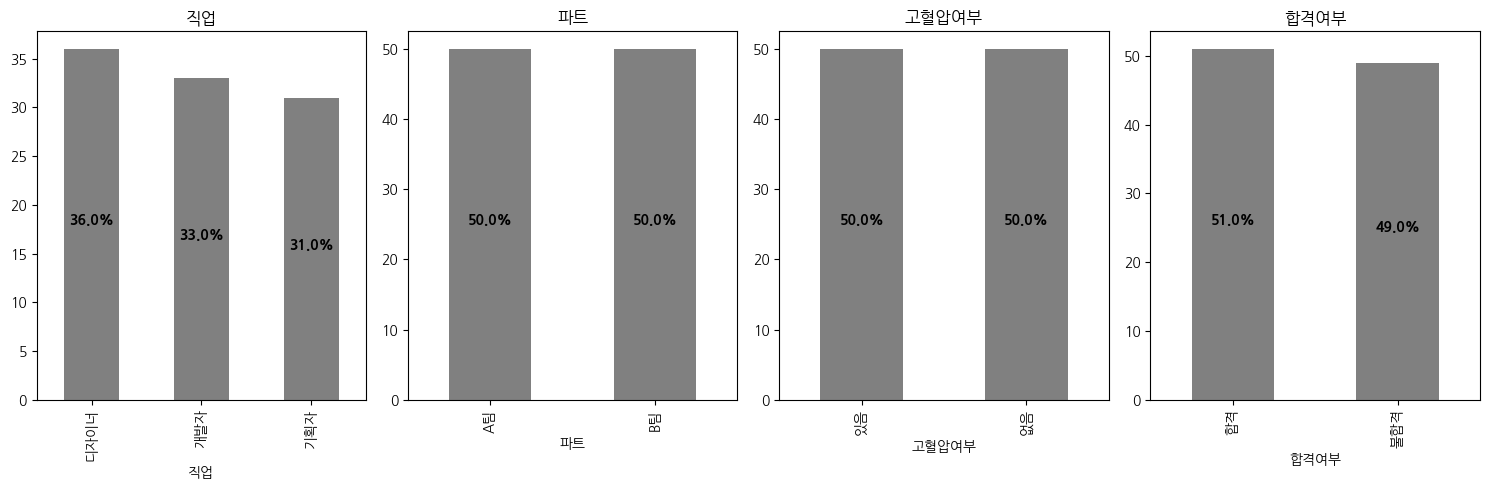

In [34]:
# 범주형 시각화

cols = df1.select_dtypes(exclude='number').columns
fig, axes = plt.subplots(1, len(cols), figsize=(15, 5))

for i, col in enumerate(cols):
    # 빈도수 계산
    counts = df1[col].value_counts()
    percents = df1[col].value_counts(normalize=True) * 100
    
    # 차트 그리기
    counts.plot(kind='bar', ax=axes[i], title=col, color='gray')
    
    # 차트 안에 비율(%) 텍스트 넣기
    for j, val in enumerate(percents):
        axes[i].text(j, counts[j]/2, f'{val:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

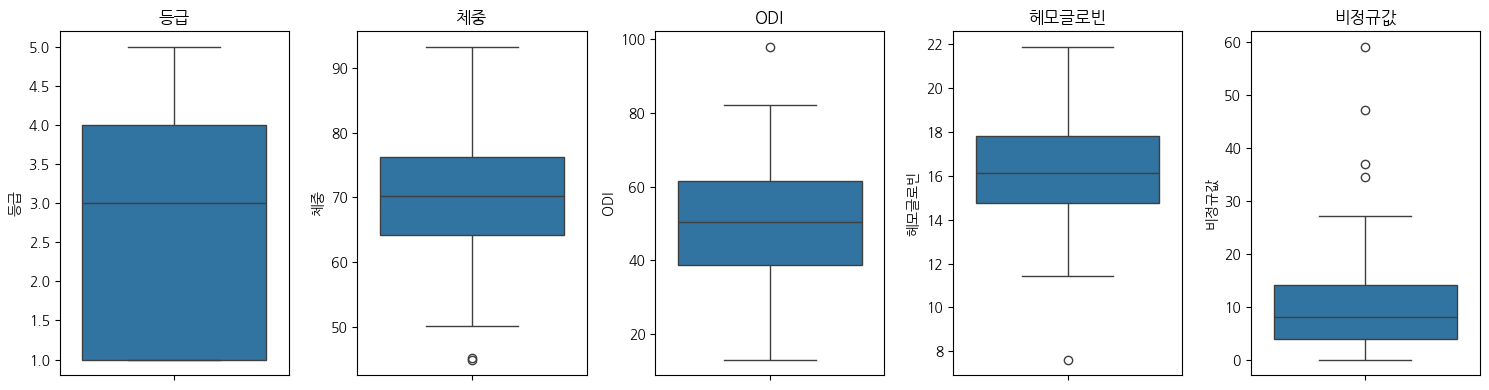

In [35]:
# 연속형 변수 이상치 확인
cols = df1.select_dtypes(include='number').columns
fig, axes = plt.subplots(1, len(cols), figsize=(15, 4))
for i, col in enumerate(cols):
    sns.boxplot(y=df1[col], ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()

Text(0.5, 1.0, '상관관계 히트맵')

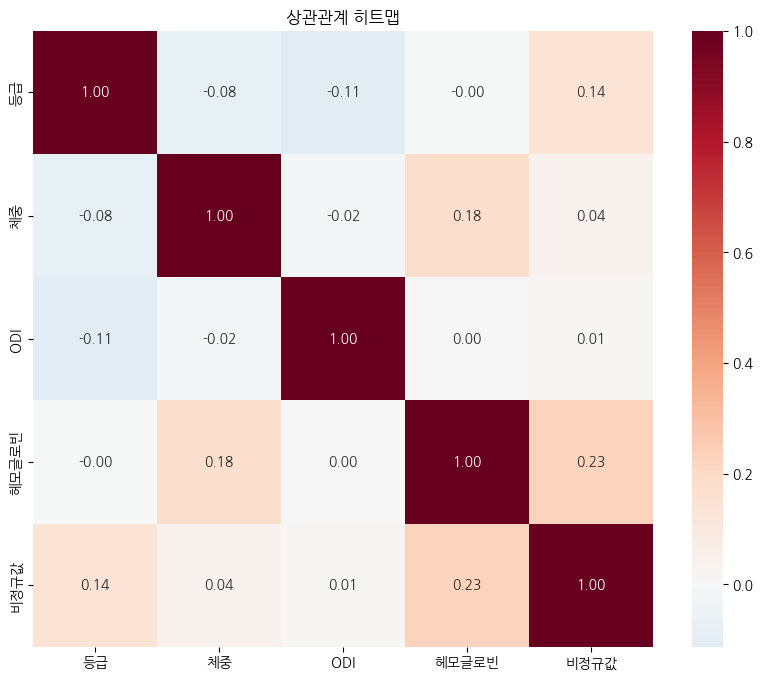

In [36]:
# 연속형 변수 간 상관관계
plt.figure(figsize=(10, 8))
corr = df1.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('상관관계 히트맵')

In [37]:
df1

,직업,파트,등급,체중,ODI,헤모글로빈,고혈압여부,합격여부,비정규값
0,기획자,A팀,4,76.468124,22.971680,12.820694,있음,불합격,13.371431
1,개발자,A팀,3,73.526350,57.015756,13.453398,없음,합격,2.012400
2,기획자,A팀,3,45.009927,26.728491,13.277419,있음,합격,8.300330
3,기획자,A팀,1,76.842628,42.342602,16.118047,있음,불합격,18.370288
4,개발자,A팀,3,82.269828,39.005733,14.407136,있음,불합격,0.934367
...,...,...,...,...,...,...,...,...,...
95,개발자,B팀,2,66.783506,61.858910,20.365111,있음,합격,23.845127
96,개발자,B팀,2,82.062701,59.492787,20.648305,있음,합격,3.800848
97,기획자,B팀,4,71.405565,16.187620,20.475713,있음,합격,8.874766
98,개발자,B팀,5,78.349116,13.151103,16.198556,있음,불합격,11.487969


<Axes: title={'center': '매출 추세'}, xlabel='파트'>

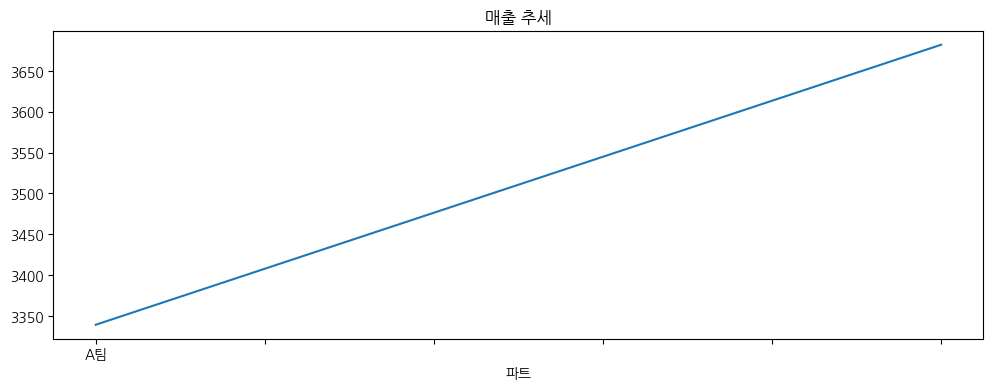

In [38]:
# 일별/월별 추세
df1.groupby('파트')['체중'].sum().plot(figsize=(12, 4), title='매출 추세')

# 가설검증

In [39]:
dfs = df1[['체중', 'ODI', '파트', '고혈압여부','등급']]  

In [40]:
compare_groups(df1, '체중', ['파트', '고혈압여부'])

,Y변수,X변수,Y타입,X타입,정규성,등분산,검정모델,p값,가설,표본수,효과크기,효과해석,검정력
0,체중,파트,연속형,범주형,정규성o,등분산,T-test(등분산),0.0001,대립,총100 (50/50),0.810,큼,98.0%
1,체중,고혈압여부,연속형,범주형,정규성o,등분산,T-test(등분산),0.4737,귀무,총100 (50/50),0.144,작음,11.0% (⚠낮음)


In [41]:
result = run_regression(dfs, '체중', ['ODI', '파트', '고혈압여부', '등급'])

In [42]:
result["model"]

,항목,값,해석
0,R²,0.1600,매우 약한 설명력 (변수들이 Y 분산의 16.0% 설명)
1,Adj R²,0.0961,변수 수 보정된 설명력
2,F통계량,2.5043,모델 유의
3,F p값,0.0211,p<0.05 → 최소 하나의 변수가 유의
4,표본수,100,
5,독립변수,4개,


In [43]:
result['baseline']

,변수,기준값(Baseline),n,비율,상태
0,파트,A팀,50,50.0%,✓적정
1,고혈압여부,있음,50,50.0%,✓적정
2,등급,1,26,26.0%,✓적정


In [44]:
result['summary']

,변수,n(비율),계수,Beta,방향,표준오차,p값,유의,95%CI,VIF,비고
0,const,-,68.6338,NaN,,3.3890,0.0000,⭐유의,"[61.903, 75.365]",-,
1,ODI,-,-0.0326,-0.0603,↓음(-),0.0528,0.5387,-,"[-0.137, 0.072]",1.05,
2,파트_B팀,50(50.0%),7.1715,0.3959,↑양(+),1.7920,0.0001,⭐유의,"[3.612, 10.731]",1.07,
3,고혈압여부_없음,50(50.0%),-1.4670,-0.0810,↓음(-),1.7408,0.4016,-,"[-4.924, 1.990]",1.01,
4,등급_2,14(14.0%),1.2937,0.0496,↑양(+),2.9107,0.6578,-,"[-4.487, 7.075]",1.36,
5,등급_3,23(23.0%),1.5302,0.0711,↑양(+),2.5454,0.5492,-,"[-3.525, 6.585]",1.53,
6,등급_4,21(21.0%),-0.5102,-0.0229,↓음(-),2.5477,0.8417,-,"[-5.570, 4.550]",1.44,
7,등급_5,16(16.0%),-0.4567,-0.0185,↓음(-),2.7976,0.8707,-,"[-6.013, 5.100]",1.40,


In [45]:
result['significant']

,변수,n(비율),계수,Beta,방향,영향도,누적영향도,p값,유의,95%CI,VIF,비고
0,파트_B팀,50(50.0%),7.1715,0.3959,↑양(+),100.0%,100.0%,0.0001,⭐유의,"[3.612, 10.731]",1.07,


# Best vs Worst grp

# Y값 분해

### 전년 전월 비교